# COGS 108 - EDA Checkpoint

# Names

- Tyler Le
- Aditya Tomar
- William Lynch
- Michael Mao
- Natalie Quach

<a id='research_question'></a>
# Research Question

Is there a positive correlation between the cost of living and the impact of natural disasters in terms of injuries, casualties, and property damage per capita at the county level? Furthermore, in which state does the impact of natural disasters affect cost of living the most?

# Setup

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# converting city to county
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm # progress bar for .apply()

# for choropleth
import plotly.express as px

# used for choropleth
from urllib.request import urlopen
import json

# filter extra noise from warnings
import warnings
warnings.filterwarnings('ignore')

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# Make plots just slightly bigger for displaying well in notebook
plt.rcParams['figure.figsize'] = (10, 5)

# Displaying figures as image
from IPython.display import Image

## Clean Table #3 (NRI)

In [51]:
df_nri = pd.read_csv('datasets/cleaned/nri.csv')

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

## EDA on Table #3
- ~~Distribution of eal_score and risk_score~~
- ~~Counties with the highest/lowest score~~
- Linear regression between risk score and frequency of natural disasters
- Linear regression between eal_score and frequency of natural disasters
- ~~Correlation between risk_score and eal_score~~

### Let's see some distributions

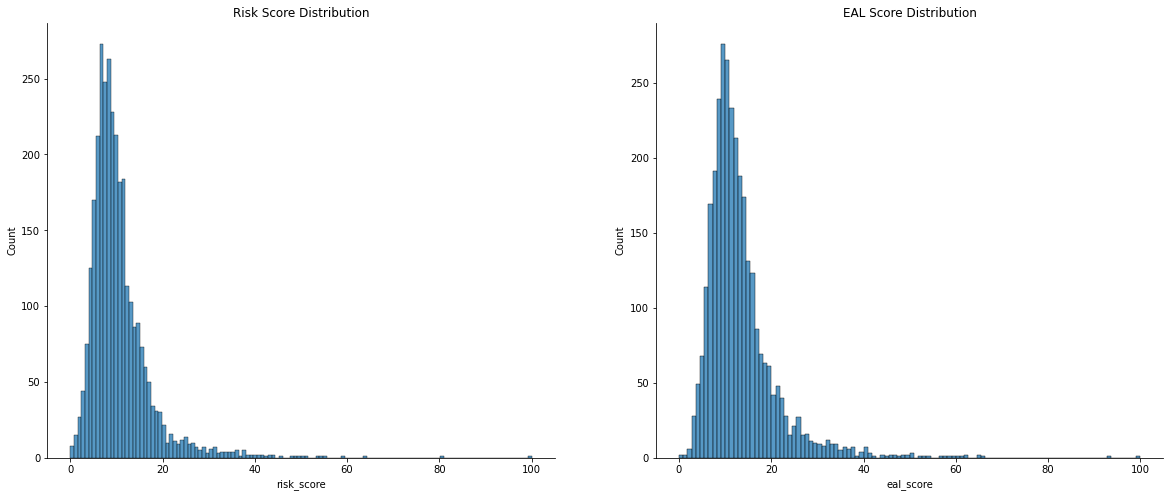

In [52]:
# get distribution of risk/eal score

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.histplot(x='risk_score', ax = ax1, data = df_nri)
sns.histplot(x='eal_score', ax = ax2, data = df_nri)

ax1.set_title('Risk Score Distribution')
ax2.set_title('EAL Score Distribution')

sns.despine()
plt.show()


In [53]:
df_nri['risk_score'].describe()

count    3142.000000
mean       10.603570
std         6.768475
min         0.000000
25%         6.689240
50%         9.089077
75%        12.533477
max       100.000000
Name: risk_score, dtype: float64

In [54]:
df_nri['eal_score'].describe()

count    3142.000000
mean       13.334561
std         7.736843
min         0.018372
25%         8.799945
50%        11.517427
75%        15.516319
max       100.000000
Name: eal_score, dtype: float64

#### The two distributions are right-skewed, so let's log-transform them.

In [55]:
# we do a log(x + .1) transformation because some x == 0 and we are unable to log those.
df_nri['risk_score_log10'] = np.log10(df_nri['risk_score'] + .1) 
df_nri['eal_score_log10'] = np.log10(df_nri['eal_score'] + .1) 

#### Let's see the log-transformed distributions.

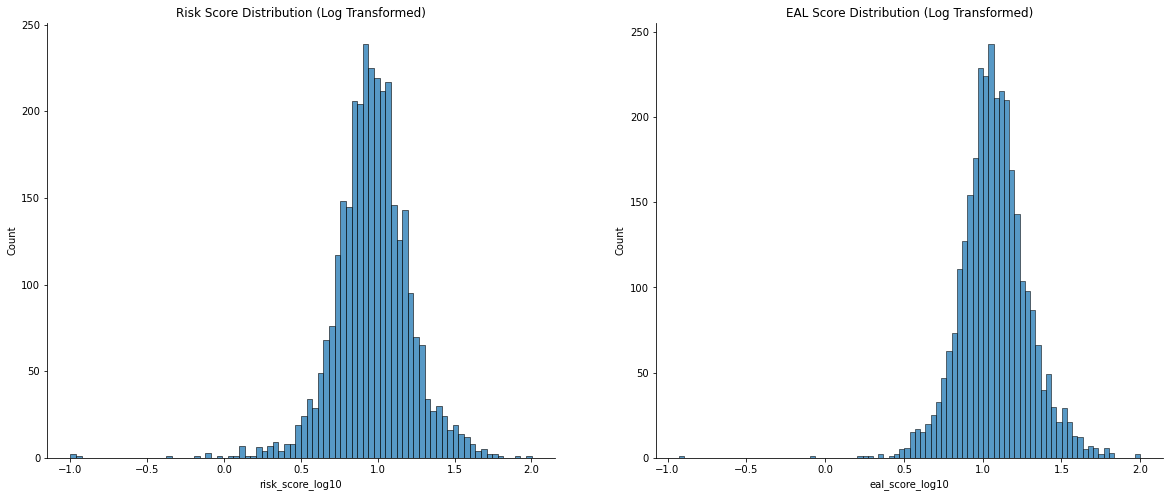

In [56]:
# get distribution of risk/eal score (log-transformed)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.histplot(x='risk_score_log10', ax = ax1, data = df_nri)
sns.histplot(x='eal_score_log10', ax = ax2, data = df_nri)

ax1.set_title('Risk Score Distribution (Log Transformed)')
ax2.set_title('EAL Score Distribution (Log Transformed)')

sns.despine()
plt.show()

### What's going on at the left-end of our distribution?

In [69]:
df_nri[df_nri['risk_score_log10'] < -.5]

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1479,Georgia,GA,13,Chattahoochee,053,11267,248.735663,0.009269,Very Low,4.693806,Very Low,13053,1,1,-0.961504,0.680680
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753
2902,Virginia,VA,51,Loudoun,107,312311,515.576847,0.000000,Very Low,17.339336,Relatively Moderate,51107,1,3,-1.000000,1.241530


In [70]:
df_nri[df_nri['eal_score_log10'] < -.5]

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753


In Chattachoochee, GA, the frequency of natural disasters are well below the national average and the area is quite poor where around twenty percent of the population lives below the poverty line. These are among the many factors that contribute to low eal and risk scores.

We can see that Loving, TX is an outlier for both graphs. In fact, Loving, TX is the least populous county in all of the U.S and it consists of flat desert terrain with not much infrastructure. It makes sense that its eal and risk scores are low.  

For Loundon, VA, natural disasters rarely hit the area so its risk score is low. However, it is the richest county in the U.S, so its expected annual loss would be rated higher due to this fact.

### Which counties have the highest and lowest EAL score?

In [57]:
df_nri.sort_values(by = ['eal_score'], ascending = False)

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,6,Los Angeles,37,9818605,4058.076752,100.000000,Very High,100.000000,Very High,6037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909
1295,California,CA,6,Santa Clara,85,1781642,1291.210369,22.951107,Relatively High,66.140195,Very High,6085,4,5,1.362692,1.821122
1285,California,CA,6,Riverside,65,2189641,7206.325086,58.865953,Very High,64.985716,Very High,6065,5,5,1.770601,1.813486
1253,California,CA,6,Alameda,1,1510271,737.476821,40.402820,Relatively High,64.799506,Very High,6001,4,5,1.607485,1.812241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Michigan,MI,26,Keweenaw,83,2156,540.111622,1.863178,Very Low,1.842344,Very Low,26083,1,1,0.292960,0.288326
1161,Alaska,AK,2,Wrangell,275,2369,2555.846403,2.229517,Very Low,1.743167,Very Low,2275,1,1,0.367266,0.265565
1155,Alaska,AK,2,Prince of Wales-Hyder,198,6172,5219.877753,1.633056,Very Low,1.511835,Very Low,2198,1,1,0.238813,0.207321
1615,Hawaii,HI,15,Kalawao,5,90,11.991403,1.636476,Very Low,0.704283,Very Low,15005,1,1,0.239669,-0.094591


### What counties have the highest and lowest risk score?

In [58]:
df_nri.sort_values(by = ['risk_score'], ascending = False)

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,6,Los Angeles,37,9818605,4058.076752,100.000000,Very High,100.000000,Very High,6037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909
1429,Florida,FL,12,Miami-Dade,86,2496435,1898.662364,63.926384,Very High,46.243703,Very High,12086,5,5,1.806359,1.665991
1285,California,CA,6,Riverside,65,2189641,7206.325086,58.865953,Very High,64.985716,Very High,6065,5,5,1.770601,1.813486
828,New York,NY,36,Bronx,5,1385108,42.050624,55.547136,Very High,25.603947,Relatively Moderate,36005,5,3,1.745443,1.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,Virginia,VA,51,Falls Church,610,12332,1.985292,0.586229,Very Low,6.946532,Very Low,51610,1,1,-0.163531,0.847975
1329,Colorado,CO,8,Douglas,35,285465,840.184666,0.341317,Very Low,20.669999,Relatively Moderate,8035,1,3,-0.355249,1.317436
1479,Georgia,GA,13,Chattahoochee,53,11267,248.735663,0.009269,Very Low,4.693806,Very Low,13053,1,1,-0.961504,0.680680
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753


### Before applying linear regression, let's take a look at our correlations and outliers.

<AxesSubplot:xlabel='risk_score', ylabel='eal_score'>

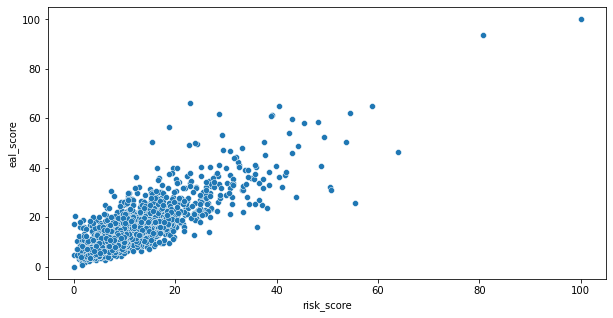

In [72]:
sns.scatterplot(x = 'risk_score', y = 'eal_score', data = df_nri)

### We can see that the most major outliers are the two on the far right. Let's find them.

In [73]:
outliers = df_nri[df_nri['risk_score'] > 80]
outliers

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,06,Los Angeles,037,9818605,4058.076752,100.000000,Very High,100.000000,Very High,06037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909


Los Angeles, CA is the most populous county is the US and Harris, TX is the third most populous county. Both are hit with natural disasters very frequently and both have a lot to lose when those disasters do strike.

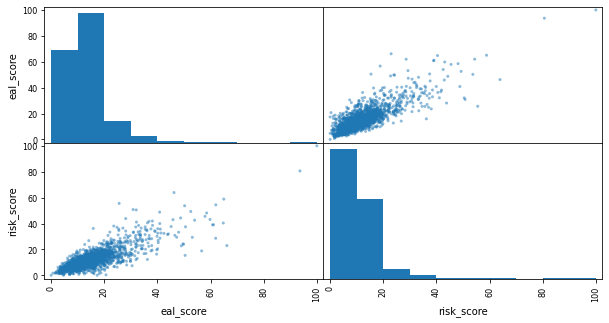

In [62]:
fig = pd.plotting.scatter_matrix(df_nri[['eal_score','risk_score']])

## We can use linear regression to see the correlation between risk_score and expected annual loss.

We will use the log-transformed values.

In [63]:
outcome, predictors = patsy.dmatrices('risk_score_log10 ~ eal_score_log10', df_nri)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       risk_score_log10   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     4481.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        11:35:38   Log-Likelihood:                 1382.7
No. Observations:                3142   AIC:                            -2761.
Df Residuals:                    3140   BIC:                            -2749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0255      0.014     

##### By our adjusted r-squared, we can see that there is a correlation between risk and expected annual loss in a county.

# Let's create a choropleth of all counties risk_score in the US

In [74]:
# we need state and county FIPS information (already included in NRI dataset)
df_nri['state_fips'] = df_nri['state_fips'].apply(lambda x: str(x).zfill(2))
df_nri['county_fips'] = df_nri['county_fips'].apply(lambda x: str(x).zfill(3))
df_nri['fips'] = df_nri['state_fips'] + df_nri['county_fips']

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

## Choropleth for risk score

In [ ]:
# View the color options below
# https://plotly.com/python/builtin-colorscales/

fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='risk_score',
                           color_continuous_scale="OrRd",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'risk_score':'risk score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image("images/risk_choropleth.png")
Image(filename='images/risk_choropleth.png') 


## Choropleth for eal score

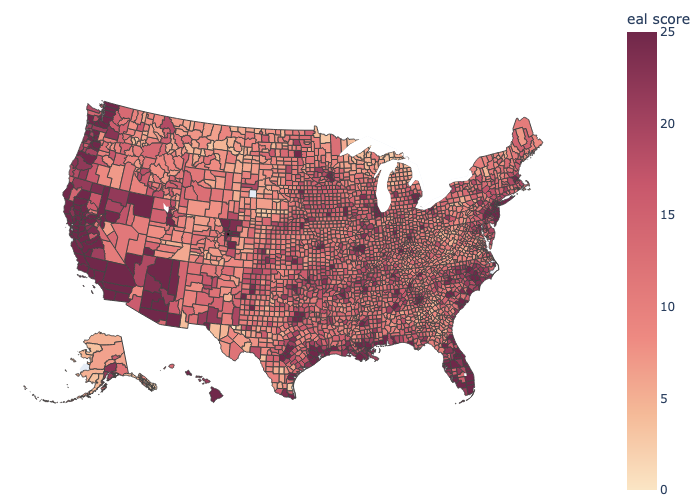

In [75]:
fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='eal_score',
                           color_continuous_scale="Burgyl",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'eal_score':'eal score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image("images/eal_choropleth.png")
Image(filename='images/eal_choropleth.png') 